In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# matplotlib 한글 꺠짐 방지
# apt-get update
# apt-get install fonts-nanum* 
# apt-get install fontconfig
# fc-cache -fv  # font 캐시 날리기
# rm -rf /home/hy1/.cache/matplotlib/  #matplotliob 폰트 캐시 날리기


In [2]:
from datetime import date, datetime
from pyspark.sql.types import *
from pyspark.sql.functions import *
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt #그래프 패키지 모듈 등록
%matplotlib inline #J.

### DW hdfs에서 파일 읽어와서 transform 진행
- hdfs InsecureClient 객체 생성
- http://localhost:9870 -> namenode url
- user = hadoop user

In [3]:
from hdfs import InsecureClient
client = InsecureClient('http://localhost:9870', user='root')

- 아래 코드는 matplotlib에 한글폰트 적용하기 위한 코드

In [4]:
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':  # 맥OS 
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # 윈도우
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    rc('font', family='NanumGothic')

#### Transform
1. 지역(광역시도)별 단위면적당 인구수
2. 지역별 단위면적당 인구수 & 코로나 확진자수
3. 지역별 단위면적당 인구수 & 코로나 확진자수, 지역별 백신접종률
4. 지역별 공공시설과 코로나 확진자 수
5. 위 데이터들로(transform data) 그래프 그릴것

- 날짜: (n일전) 자동화 되게해야하니까 날짜계산코드 이전노트에서 들고오자

In [5]:
def cal_std_day(befor_day):
    x = dt.datetime.now() - dt.timedelta(befor_day)
    year = x.year
    month = x.month if x.month >= 10 else '0'+ str(x.month)
    day = x.day if x.day >= 10 else '0' + str(x.day)
    return str(year) + '-' + str(month) + '-' + str(day)

#### 1. 지역(광역시도)별 단위면적당 인구수
필요data
- 지역별 인구 & 면적 데이터: /corona_data/tmp 안에 있음

In [6]:
# 지역 면적 데이터 읽어오기
# 파일 encoding=CP949
area = spark.read.csv('/corona_data/tmp/sido_area.csv', encoding='CP949', header=True)
area.show()
#ratio는 전체 영토 대비 차지 비율

[Stage 1:>                                                          (0 + 1) / 1]

+----+------+-----+
| loc|  area|ratio|
+----+------+-----+
|서울|  605 |  0.6|
|부산|  770 |  0.8|
|대구|  883 |  0.9|
|인천| 1065 |  1.1|
|광주|  501 |  0.5|
|대전|  540 |  0.5|
|울산| 1062 |  1.1|
|세종|  465 |  0.5|
|경기|10195 | 10.2|
|강원|16830 | 16.8|
|충북| 7407 |  7.4|
|충남| 8246 |  8.2|
|전북| 8070 |  8.0|
|전남|12348 | 12.3|
|경북|19034 | 19.0|
|경남|10541 | 10.5|
|제주| 1850 |  1.8|
+----+------+-----+



In [7]:
# 지역 인구 데이터 읽어오기
# 인구 데이터 특징: 3-4년에 한번 update됨
    # airflow구성시 매일 수집 등 자동 수집 구현할 필요 X
# 파일 encoding=CP949
popu = spark.read.csv('/corona_data/tmp/sido_population.csv', encoding='CP949', header=True)
popu.show()
#ratio는 전체 영토 대비 차지 비율

+----+---------+---------+---------+
| loc|    total|     male|   female|
+----+---------+---------+---------+
|전국|52739009 |26360035 |26378974 |
|서울| 9736027 | 4721977 | 5014050 |
|부산| 3396109 | 1663619 | 1732490 |
|대구| 2412642 | 1189901 | 1222741 |
|인천| 3014739 | 1513277 | 1501462 |
|광주| 1462545 |  724178 |  738367 |
|대전| 1469543 |  732593 |  736950 |
|울산| 1138419 |  586031 |  552388 |
|세종|  376779 |  188619 |  188160 |
|경기|13925862 | 7038296 | 6887566 |
|강원| 1555876 |  783743 |  772133 |
|충북| 1633472 |  832743 |  800729 |
|충남| 2181835 | 1120429 | 1061406 |
|전북| 1817186 |  905672 |  911514 |
|전남| 1865459 |  943018 |  922441 |
|경북| 2677709 | 1355128 | 1322581 |
|경남| 3377331 | 1709989 | 1667342 |
|제주|  697476 |  350822 |  346654 |
+----+---------+---------+---------+



### 지역별 단위면적과 인구수 구하기 진행중...
- 면적과 인구관련 data는 자주 변경x ==> 자동화에서 제외
- ** DM DB에 table로 저장

In [9]:
# 면적data와 인구 data loc 기준 join 후 가공 data를 생성
# df join(inner join): 양쪽 df에 모두 존재하는 key에 대해서만 join을 진행
                        # 인구data: 전국 포함 / 면적data: 전국 미포함 ==> inner join 시 제외됨
area_pop = area.join(popu, on='loc')
area_pop.show()

[Stage 5:>                                                          (0 + 1) / 1]

+----+------+-----+---------+--------+--------+
| loc|  area|ratio|    total|    male|  female|
+----+------+-----+---------+--------+--------+
|서울|  605 |  0.6| 9736027 |4721977 |5014050 |
|부산|  770 |  0.8| 3396109 |1663619 |1732490 |
|대구|  883 |  0.9| 2412642 |1189901 |1222741 |
|인천| 1065 |  1.1| 3014739 |1513277 |1501462 |
|광주|  501 |  0.5| 1462545 | 724178 | 738367 |
|대전|  540 |  0.5| 1469543 | 732593 | 736950 |
|울산| 1062 |  1.1| 1138419 | 586031 | 552388 |
|세종|  465 |  0.5|  376779 | 188619 | 188160 |
|경기|10195 | 10.2|13925862 |7038296 |6887566 |
|강원|16830 | 16.8| 1555876 | 783743 | 772133 |
|충북| 7407 |  7.4| 1633472 | 832743 | 800729 |
|충남| 8246 |  8.2| 2181835 |1120429 |1061406 |
|전북| 8070 |  8.0| 1817186 | 905672 | 911514 |
|전남|12348 | 12.3| 1865459 | 943018 | 922441 |
|경북|19034 | 19.0| 2677709 |1355128 |1322581 |
|경남|10541 | 10.5| 3377331 |1709989 |1667342 |
|제주| 1850 |  1.8|  697476 | 350822 | 346654 |
+----+------+-----+---------+--------+--------+



In [11]:
# 단위면적당 인구수 정보를 갖고있는 가공 df 생성
# 연산 결과는 실수data이므로 올림처리해서 정수
area_pop_v1 = area_pop.select(area_pop.loc,
                           (ceil(area_pop.total/area_pop.area)).alias('popu_density'))
area_pop_v1.show()

+----+------------+
| loc|popu_density|
+----+------------+
|서울|       16093|
|부산|        4411|
|대구|        2733|
|인천|        2831|
|광주|        2920|
|대전|        2722|
|울산|        1072|
|세종|         811|
|경기|        1366|
|강원|          93|
|충북|         221|
|충남|         265|
|전북|         226|
|전남|         152|
|경북|         141|
|경남|         321|
|제주|         378|
+----+------------+



### 지역별 코로나 환자 데이터와 지역/인구 데이터와의 관계
- 지역별 누적 발생 현황: deCnt
- 지역별 인구 10만명 당 발생률: qurRate

In [13]:
# 특정일까지의 누적 데이터를 활용해서 지역/인구 데이터와의 관계
cal_std_day(365*3+3)

'2022-01-18'

In [14]:
# api data > hdfs 저장 > spark.read.json('hdfs url/파일경로/파일명', encoding=) -> df로 읽어오기
# 9000 : 기본 hdfs연결 port
file_dir = 'hdfs://localhost:9000/corona_data/patient/'
file_name = 'corona_patient_'+cal_std_day(365*3+3)+'.json'
fname = file_dir+file_name
tmpAPI = spark.read.json(fname, encoding='UTF-8')
tmpAPI.show()

# json파일을 spark.df로 읽어옴
# 최상위 lecel key df의 컬럼으로 구성됨
# 1행만 갖고있는 df
# 실제 사용할 data는 items 컬럼에 list type으로 읽어왔음

[Stage 11:>                                                         (0 + 1) / 1]

+----------------------+---------+------+----------+--------------+----------+
|                 items|numOfRows|pageNo|resultCode|     resultMsg|totalCount|
+----------------------+---------+------+----------+--------------+----------+
|[{326, 40625, 인천,...|      500|     1|        00|NORMAL SERVICE|        19|
+----------------------+---------+------+----------+--------------+----------+



In [ ]:
# items 가 필요하고 1개의 행으로만 되어있으므로 첫째행의 값을 가져오는 first()활용
# show와 다르게 반환값이 있다.
# 지금은 데이터가 필요한거니까 반드시 반환값이 있는 메소드 이용이 필요한 상황

In [17]:
tmpFin = tmpAPI.select('items').first()
#tmpFin
#tmpFin['items'] > 리스트의 객체가 각 행을 만들 수 있는 형태
# spark에서 DF만들기
coPatient=spark.createDataFrame(tmpFin['items']) #json > DF > 필요컬럼추출> DF로 구성한 과정

In [18]:
coPatient.show()

+--------+------+-----+-------+-----------------+------+------------+----------+-----------+-----------+-------+----------+
|deathCnt|defCnt|gubun|gubunCn|          gubunEn|incDec|isolClearCnt|isolIngCnt|localOccCnt|overFlowCnt|qurRate|    stdDay|
+--------+------+-----+-------+-----------------+------+------------+----------+-----------+-----------+-------+----------+
|     326| 40625| 인천|   仁川|          Incheon|   196|       35422|         0|        177|         19|   1378|2022-01-18|
|     123| 12555| 충북|   忠北|Chungcheongbuk-do|    59|       11766|         0|         55|          4|    786|2022-01-18|
|     110| 13838| 강원|   江原|       Gangwon-do|    94|       12657|         0|         94|          0|    899|2022-01-18|
|     344| 28102| 부산|   釜山|            Busan|   114|       25796|         0|        102|         12|    839|2022-01-18|
|      65|  7459| 울산|   蔚山|            Ulsan|    35|        7107|         0|         33|          2|    665|2022-01-18|
|      60| 10475| 광주|   光州| 

- 일간 수집해야하는 data
- 최종부서에서 사용할 data DW -> DM까지 저장되어야하는 data
    - 사용 결정 컬럼만 추출해서 DM DB에 저장
    - 운영DB에는 다른 data와 연결 가공해서 저장

In [21]:
coDMFin = coPatient.select(coPatient.gubun.alias('loc'),
                           coPatient.defCnt,
                           coPatient.qurRate) #지역별 코로나환자 누적 발생수/단위당 발생률 현황
coDMFin.show()

+----+------+-------+
| loc|defCnt|qurRate|
+----+------+-------+
|인천| 40625|   1378|
|충북| 12555|    786|
|강원| 13838|    899|
|부산| 28102|    839|
|울산|  7459|    665|
|광주| 10475|    727|
|합계|700102|   1356|
|세종|  2388|    642|
|검역|  7960|      -|
|대구| 25155|   1055|
|경북| 16962|    646|
|경남| 22778|    687|
|서울|243337|   2559|
|전남|  7935|    433|
|제주|  4900|    724|
|경기|210984|   1555|
|전북| 11245|    629|
|충남| 20142|    950|
|대전| 13262|    913|
+----+------+-------+



- 인구 면적 data와 발생현황 관계 data
    - 인구 면적 data에 검역과 합계 data는 없음
    - 검역과 합계는 처리되어야함

In [24]:
# area_pop: 인구면적
# coDMFin: 2022-01-18 기준 누적 발생 현황
coRate = area_pop_v1.join(coDMFin, on='loc').orderBy(col('loc'))
coRate.show()

+----+------------+------+-------+
| loc|popu_density|defCnt|qurRate|
+----+------------+------+-------+
|강원|          93| 13838|    899|
|경기|        1366|210984|   1555|
|경남|         321| 22778|    687|
|경북|         141| 16962|    646|
|광주|        2920| 10475|    727|
|대구|        2733| 25155|   1055|
|대전|        2722| 13262|    913|
|부산|        4411| 28102|    839|
|서울|       16093|243337|   2559|
|세종|         811|  2388|    642|
|울산|        1072|  7459|    665|
|인천|        2831| 40625|   1378|
|전남|         152|  7935|    433|
|전북|         226| 11245|    629|
|제주|         378|  4900|    724|
|충남|         265| 20142|    950|
|충북|         221| 12555|    786|
+----+------------+------+-------+



In [25]:
# 그래프 생성
# coRate DF는 spark sql df. 이걸 pandas df로 변경 후 그래프 그리기
coRate.printSchema()

root
 |-- loc: string (nullable = true)
 |-- popu_density: long (nullable = true)
 |-- defCnt: string (nullable = true)
 |-- qurRate: string (nullable = true)



In [26]:
pdCoRate = coRate.toPandas()

In [27]:
pdCoRate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   loc           17 non-null     object
 1   popu_density  17 non-null     int64 
 2   defCnt        17 non-null     object
 3   qurRate       17 non-null     object
dtypes: int64(1), object(3)
memory usage: 672.0+ bytes


In [47]:
# 컬럼 타입 변경
pdCoRate['qurRate'] = pdCoRate['qurRate'].astype(int)
pdCoRate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   loc           17 non-null     object
 1   popu_density  17 non-null     int64 
 2   defCnt        17 non-null     int64 
 3   qurRate       17 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 672.0+ bytes


<Axes: xlabel='popu_density', ylabel='qurRate'>

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

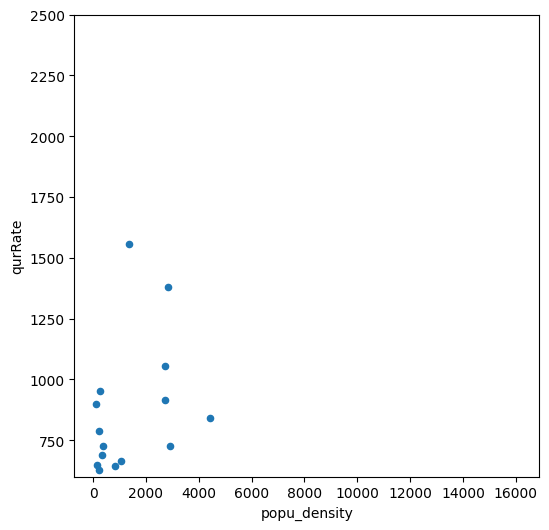

In [51]:
pdCoRate.plot(kind='scatter',
              x = 'popu_density',
              #y = 'defCnt',
              y = 'qurRate',
              #xlim = (0, 8000),
              ylim = (600, 2500),
              figsize = (6, 6))

### 백신 접종 현황 데이터
- 지역별 3차 접종현황 데이터와 인구대비 접종율 데이터
    - dm db에 저장

In [56]:
# 인구 data
popu
# 백신 data
file_dir_vac = '/corona_data/vaccine/'
file_name = 'corona_vaccine_'+cal_std_day(365*3+3)+'.json'
fname = file_dir_vac+file_name
vaccine = spark.read.json(fname)
vaccine.show()
vaccine.select('data').first()
vaccine.select('data').first()['data']


DataFrame[loc: string, total: string, male: string, female: string]

+----------------------+---------------------------+
|                  data|                       meta|
+----------------------+---------------------------+
|[{광주, 1247764, 12...|{{지역, 1차 접종 누적, 2...|
+----------------------+---------------------------+



Row(data=[Row(loc='광주', v1='1247764', v2='1220758.0', v3='682394.0'), Row(loc='울산', v1='956895', v2='933311.0', v3='476692.0'), Row(loc='인천', v1='2532911', v2='2484196.0', v3='1330273.0'), Row(loc='대전', v1='1231435', v2='1203724.0', v3='628469.0'), Row(loc='대구', v1='1997407', v2='1945813.0', v3='978794.0'), Row(loc='부산', v1='2849093', v2='2788089.0', v3='1554554.0'), Row(loc='서울', v1='8239400', v2='8090244.0', v3='4304485.0'), Row(loc='전국', v1='44505276', v2='43582128.0', v3='23741205.0'), Row(loc='세종', v1='290455', v2='282507.0', v3='138100.0'), Row(loc='경기', v1='11652853', v2='11414202.0', v3='5970505.0'), Row(loc='제주', v1='580579', v2='566811.0', v3='295807.0'), Row(loc='경남', v1='2848083', v2='2783896.0', v3='1517240.0'), Row(loc='경북', v1='2260963', v2='2202814.0', v3='1247047.0'), Row(loc='전남', v1='1632045', v2='1602479.0', v3='1031459.0'), Row(loc='전북', v1='1574779', v2='1547262.0', v3='958100.0'), Row(loc='충남', v1='1870124', v2='1830143.0', v3='1048429.0'), Row(loc='충북', v1='1408

[Row(loc='광주', v1='1247764', v2='1220758.0', v3='682394.0'),
 Row(loc='울산', v1='956895', v2='933311.0', v3='476692.0'),
 Row(loc='인천', v1='2532911', v2='2484196.0', v3='1330273.0'),
 Row(loc='대전', v1='1231435', v2='1203724.0', v3='628469.0'),
 Row(loc='대구', v1='1997407', v2='1945813.0', v3='978794.0'),
 Row(loc='부산', v1='2849093', v2='2788089.0', v3='1554554.0'),
 Row(loc='서울', v1='8239400', v2='8090244.0', v3='4304485.0'),
 Row(loc='전국', v1='44505276', v2='43582128.0', v3='23741205.0'),
 Row(loc='세종', v1='290455', v2='282507.0', v3='138100.0'),
 Row(loc='경기', v1='11652853', v2='11414202.0', v3='5970505.0'),
 Row(loc='제주', v1='580579', v2='566811.0', v3='295807.0'),
 Row(loc='경남', v1='2848083', v2='2783896.0', v3='1517240.0'),
 Row(loc='경북', v1='2260963', v2='2202814.0', v3='1247047.0'),
 Row(loc='전남', v1='1632045', v2='1602479.0', v3='1031459.0'),
 Row(loc='전북', v1='1574779', v2='1547262.0', v3='958100.0'),
 Row(loc='충남', v1='1870124', v2='1830143.0', v3='1048429.0'),
 Row(loc='충북', v

In [57]:
tmpVac = spark.createDataFrame(vaccine.select('data').first()['data'])
tmpVac.show()

[Stage 42:>                                                         (0 + 1) / 1]

+----+--------+----------+----------+
| loc|      v1|        v2|        v3|
+----+--------+----------+----------+
|광주| 1247764| 1220758.0|  682394.0|
|울산|  956895|  933311.0|  476692.0|
|인천| 2532911| 2484196.0| 1330273.0|
|대전| 1231435| 1203724.0|  628469.0|
|대구| 1997407| 1945813.0|  978794.0|
|부산| 2849093| 2788089.0| 1554554.0|
|서울| 8239400| 8090244.0| 4304485.0|
|전국|44505276|43582128.0|23741205.0|
|세종|  290455|  282507.0|  138100.0|
|경기|11652853|11414202.0| 5970505.0|
|제주|  580579|  566811.0|  295807.0|
|경남| 2848083| 2783896.0| 1517240.0|
|경북| 2260963| 2202814.0| 1247047.0|
|전남| 1632045| 1602479.0| 1031459.0|
|전북| 1574779| 1547262.0|  958100.0|
|충남| 1870124| 1830143.0| 1048429.0|
|충북| 1408620| 1379378.0|  783588.0|
|강원| 1331870| 1306501.0|  795269.0|
+----+--------+----------+----------+



In [58]:
# 인구대비 3차 접종률 컬럼 추가
popVac = tmpVac.join(popu, on='loc')
popVac.show()

+----+--------+----------+----------+---------+---------+---------+
| loc|      v1|        v2|        v3|    total|     male|   female|
+----+--------+----------+----------+---------+---------+---------+
|광주| 1247764| 1220758.0|  682394.0| 1462545 |  724178 |  738367 |
|울산|  956895|  933311.0|  476692.0| 1138419 |  586031 |  552388 |
|인천| 2532911| 2484196.0| 1330273.0| 3014739 | 1513277 | 1501462 |
|대전| 1231435| 1203724.0|  628469.0| 1469543 |  732593 |  736950 |
|대구| 1997407| 1945813.0|  978794.0| 2412642 | 1189901 | 1222741 |
|부산| 2849093| 2788089.0| 1554554.0| 3396109 | 1663619 | 1732490 |
|서울| 8239400| 8090244.0| 4304485.0| 9736027 | 4721977 | 5014050 |
|전국|44505276|43582128.0|23741205.0|52739009 |26360035 |26378974 |
|세종|  290455|  282507.0|  138100.0|  376779 |  188619 |  188160 |
|경기|11652853|11414202.0| 5970505.0|13925862 | 7038296 | 6887566 |
|제주|  580579|  566811.0|  295807.0|  697476 |  350822 |  346654 |
|경남| 2848083| 2783896.0| 1517240.0| 3377331 | 1709989 | 1667342 |
|경북|

In [60]:
# V2와 total 활용 가공 데이터 : v3 수집 잘못함 - 변경해야 함
popVac2 = popVac.select('loc', 'v2',
                        ceil((popVac.v2 / popVac.total)*100).alias('vacPopRate'))
popVac2.show()
# dm db 저장

+----+----------+----------+
| loc|        v2|vacPopRate|
+----+----------+----------+
|광주| 1220758.0|        84|
|울산|  933311.0|        82|
|인천| 2484196.0|        83|
|대전| 1203724.0|        82|
|대구| 1945813.0|        81|
|부산| 2788089.0|        83|
|서울| 8090244.0|        84|
|전국|43582128.0|        83|
|세종|  282507.0|        75|
|경기|11414202.0|        82|
|제주|  566811.0|        82|
|경남| 2783896.0|        83|
|경북| 2202814.0|        83|
|전남| 1602479.0|        86|
|전북| 1547262.0|        86|
|충남| 1830143.0|        84|
|충북| 1379378.0|        85|
|강원| 1306501.0|        84|
+----+----------+----------+



- 코로나 발생 현황 vs 접종률 관계 확인 위한 그래프
    - 그래프 그리기 위한 data구성
    - 운영 db에 저장
    - 지역별 코로나 발생률과 접종률

In [62]:
coRate.columns
popVac2.columns
coVacPact = coRate.join(popVac2, on='loc')\
        .select('loc','qurRate','vacPopRate')

['loc', 'popu_density', 'defCnt', 'qurRate']

['loc', 'v2', 'vacPopRate']

In [63]:
coVacPact.printSchema()

root
 |-- loc: string (nullable = true)
 |-- qurRate: string (nullable = true)
 |-- vacPopRate: long (nullable = true)



In [66]:
pdVacPat = coVacPact.toPandas()
pdVacPat.info()
# str == object type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   loc         17 non-null     object
 1   qurRate     17 non-null     object
 2   vacPopRate  17 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 536.0+ bytes


In [67]:
pdVacPat['qurRate'] = pdVacPat['qurRate'].astype(int)
pdVacPat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   loc         17 non-null     object
 1   qurRate     17 non-null     int64 
 2   vacPopRate  17 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 536.0+ bytes


<Axes: xlabel='vacPopRate', ylabel='qurRate'>

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

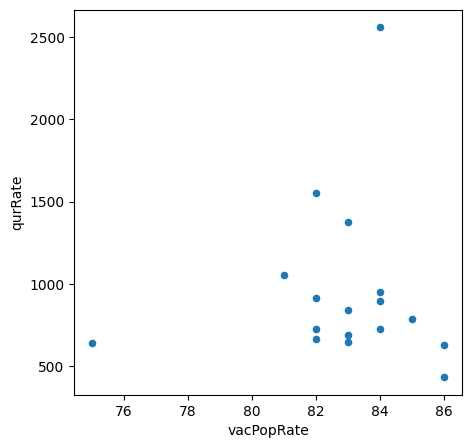

In [69]:
pdVacPat.plot(kind='scatter',
              x = 'vacPopRate',
              y = 'qurRate',
              figsize=(5,5))

###  지역별 다중이용시설 data와 인구와의 가공 data 구성
- 지역별 다중이용시설과 코로나 발생현황에 대한 관계
- 지역별 인구 10만명 당 다중이용시설 개수

In [70]:
# 인구data
popu

DataFrame[loc: string, total: string, male: string, female: string]

In [72]:
# 다중이용시설
fasc= spark.read.csv('/corona_data/tmp/전국다중이용시설.csv', encoding='CP949', header=True)
fasc.show()

+----+----+------+---------------------+--------------+----------------+
|연도|광역|시군구|               시설명|사업자등록번호|          시설군|
+----+----+------+---------------------+--------------+----------------+
|2020|강원|강릉시|     (주)경포솔향온천|  127-86-57613|          목욕장|
|2020|강원|강릉시|       24시황실사우나|  226-33-03247|          목욕장|
|2020|강원|강릉시|         강릉고려병원|  226-82-03662|        의료기관|
|2020|강원|강릉시|   강릉고속버스터미널|  219-81-01636|여객자동차터미널|
|2020|강원|강릉시|       강릉교육문화관|  226-83-03107|          도서관|
|2020|강원|강릉시|         강릉동인병원|  226-82-01835|        의료기관|
|2020|강원|강릉시|         강릉동인병원|  226-82-01835|        장례식장|
|2020|강원|강릉시|강릉동인병원 장례식장|  226-90-93776|        장례식장|
|2020|강원|강릉시|   강릉빛나라어린이집|  226-82-12841|        어린이집|
|2020|강원|강릉시|     강릉삼성어린이집|  226-80-04288|        어린이집|
|2020|강원|강릉시|          강릉시 기관|  226-83-00245|          도서관|
|2020|강원|강릉시|          강릉시 기관|  226-83-00245|        어린이집|
|2020|강원|강릉시|          강릉시 기관|  226-83-00245|          박물관|
|2020|강원|강릉시|         강릉시보건소|  226-83-00264|        의료기관|

In [73]:
# 데이터 열어봤더니 지역별로 다중이용시설 갯수가 있는 게 아니라
# 영업점 별로 data가 구성되어있네
# 광역 행의 갯수를 세서 다중이용시설의 수를 연산 - 인구대비 다중이용시설 수
fasc_v1 = fasc.groupby(col('광역').alias('loc')).agg(count('*').alias('fascCnt'))
fasc_v1.show()

[Stage 65:>                                                         (0 + 1) / 1]

+----+-------+
| loc|fascCnt|
+----+-------+
|경북|    944|
|대전|    767|
|전북|    759|
|충북|    617|
|울산|    431|
|경남|   1357|
|제주|    310|
|충남|    824|
|전남|    825|
|인천|   1386|
|부산|   1462|
|대구|   1015|
|경기|   6303|
|서울|   5224|
|광주|    732|
|세종|    243|
|강원|    584|
+----+-------+



In [83]:
# 인구data와 결합
# dmdb에 저장
popFac = popu.join(fasc_v1, on='loc')\
        .select('loc', 'total', 'fascCnt',
                ceil((col('fascCnt')/col('total')*100000)).alias('facPop')) # 10만명당 다중이용시설 몇개?
popFac.show()

+----+---------+-------+------+
| loc|    total|fascCnt|facPop|
+----+---------+-------+------+
|경북| 2677709 |    944|    36|
|대전| 1469543 |    767|    53|
|전북| 1817186 |    759|    42|
|충북| 1633472 |    617|    38|
|울산| 1138419 |    431|    38|
|경남| 3377331 |   1357|    41|
|제주|  697476 |    310|    45|
|충남| 2181835 |    824|    38|
|전남| 1865459 |    825|    45|
|인천| 3014739 |   1386|    46|
|부산| 3396109 |   1462|    44|
|대구| 2412642 |   1015|    43|
|경기|13925862 |   6303|    46|
|서울| 9736027 |   5224|    54|
|광주| 1462545 |    732|    51|
|세종|  376779 |    243|    65|
|강원| 1555876 |    584|    38|
+----+---------+-------+------+



In [84]:
coRate.show(1)
popFac.show(1)

+----+------------+------+-------+
| loc|popu_density|defCnt|qurRate|
+----+------------+------+-------+
|강원|          93| 13838|    899|
+----+------------+------+-------+
only showing top 1 row

+----+--------+-------+------+
| loc|   total|fascCnt|facPop|
+----+--------+-------+------+
|경북|2677709 |    944|    36|
+----+--------+-------+------+
only showing top 1 row



In [87]:
# 운영db저장
coFac = coRate.join(popFac, on='loc').select('loc', 'qurRate', 'facPop')
coFac.show()

+----+-------+------+
| loc|qurRate|facPop|
+----+-------+------+
|인천|   1378|    46|
|충북|    786|    38|
|강원|    899|    38|
|부산|    839|    44|
|울산|    665|    38|
|광주|    727|    51|
|세종|    642|    65|
|대구|   1055|    43|
|경북|    646|    36|
|경남|    687|    41|
|서울|   2559|    54|
|전남|    433|    45|
|제주|    724|    45|
|경기|   1555|    46|
|전북|    629|    42|
|충남|    950|    38|
|대전|    913|    53|
+----+-------+------+



In [89]:
pdCoFac = coFac.toPandas()
pdCoFac.info()

[Stage 121:============================>                            (1 + 1) / 2]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   loc      17 non-null     object
 1   qurRate  17 non-null     object
 2   facPop   17 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 536.0+ bytes


In [90]:
pdCoFac['qurRate'] = pdCoFac['qurRate'].astype(int)
pdCoFac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   loc      17 non-null     object
 1   qurRate  17 non-null     int64 
 2   facPop   17 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 536.0+ bytes


<Axes: xlabel='facPop', ylabel='qurRate'>

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

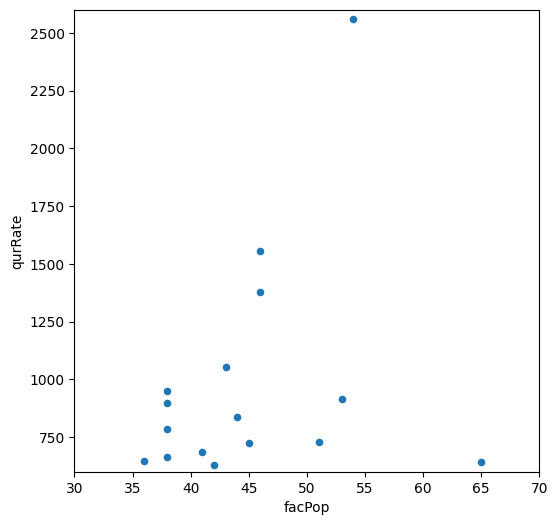

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


In [93]:
pdCoFac.plot(kind='scatter',
             x = 'facPop',
             y = 'qurRate',
             ylim = (600,2600),
             xlim = (30,70),
             figsize = (6,6))